# 🗣️ Conversational RAG using Memory

In this notebook, we'll explore how to incorporate memory into a RAG pipeline to enable conversations with our documents, using an `InMemoryChatMessageStore`, a `ChatMessageRetriever`, and a `ChatMessageWriter`.

**Useful Sources**

* [📖 Docs](https://docs.haystack.deepset.ai/docs/intro)
* [📚 Tutorials](https://haystack.deepset.ai/tutorials)

## Installation

Install Haystack, `haystack-experimental` and `datasets` with pip:

In [ ]:
!pip install -U haystack-ai datasets

## Enter OpenAI API key

In [2]:
import os
from getpass import getpass

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

Enter OpenAI API key:··········


## Create DocumentStore and Index Documents

Create an index with [seven-wonders](https://huggingface.co/datasets/bilgeyucel/seven-wonders) dataset:

In [3]:
from haystack import Document
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.document_stores.in_memory import InMemoryDocumentStore
from datasets import load_dataset

dataset = load_dataset("bilgeyucel/seven-wonders", split="train")
docs = [Document(content=doc["content"], meta=doc["meta"]) for doc in dataset]

document_store = InMemoryDocumentStore()
document_store.write_documents(documents=docs)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/46.0 [00:00<?, ?B/s]

(…)-00000-of-00001-4077bd623d55100a.parquet:   0%|          | 0.00/119k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/151 [00:00<?, ? examples/s]

151

## Create Memory

Memory, so the conversation history, is saved as `ChatMessage` objects in a `InMemoryChatMessageStore`. When required, you can retrieve the conversation history from the chat message store using `ChatMessageRetriever`.

To store memory, initialize an `InMemoryChatMessageStore`, a `ChatMessageRetriever` and a `ChatMessageWriter`. Import these components from the [`haystack-experimental`](https://github.com/deepset-ai/haystack-experimental) package:

In [4]:
from haystack_experimental.chat_message_stores.in_memory import InMemoryChatMessageStore
from haystack_experimental.components.retrievers import ChatMessageRetriever
from haystack_experimental.components.writers import ChatMessageWriter

# Memory components
memory_store = InMemoryChatMessageStore()
memory_retriever = ChatMessageRetriever(memory_store)
memory_writer = ChatMessageWriter(memory_store)

## Prompt Template for RAG with Memory

Prepare a prompt template for RAG and additionally, add another section for memory. Memory info will be retrieved by `ChatMessageRetriever` from the `InMemoryChatMessageStore` and injected into the prompt through `memories` prompt variable.

In [5]:
from haystack.dataclasses import ChatMessage

system_message = ChatMessage.from_system("You are a helpful AI assistant using provided supporting documents and conversation history to assist humans")

user_message_template ="""Given the conversation history and the provided supporting documents, give a brief answer to the question.
Note that supporting documents are not part of the conversation. If question can't be answered from supporting documents, say so.

    Conversation history:
    {% for memory in memories %}
        {{ memory.text }}
    {% endfor %}

    Supporting documents:
    {% for doc in documents %}
        {{ doc.content }}
    {% endfor %}

    \nQuestion: {{query}}
    \nAnswer:
"""
user_message = ChatMessage.from_user(user_message_template)

## Build the Pipeline

Add components for RAG and memory to build your pipeline. Incorporate the custom `ListJoiner` component into your pipeline to handle messages from both the user and the LLM, writing them to the memory store.

> **Note**: The `ListJoiner` component will be available in Haystack starting from version 2.8.0!

In [6]:
from itertools import chain
from typing import Any

from haystack import component
from haystack.core.component.types import Variadic


@component
class ListJoiner:
    def __init__(self, _type: Any):
        component.set_output_types(self, values=_type)

    def run(self, values: Variadic[Any]):
        result = list(chain(*values))
        return {"values": result}

In [7]:
from typing import List
from haystack import Pipeline
from haystack.components.builders import ChatPromptBuilder, PromptBuilder
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.generators import OpenAIGenerator
from haystack.components.converters import OutputAdapter

pipeline = Pipeline()

# components for RAG
pipeline.add_component("retriever", InMemoryBM25Retriever(document_store=document_store, top_k=3))
pipeline.add_component("prompt_builder", ChatPromptBuilder(variables=["query", "documents", "memories"], required_variables=["query", "documents", "memories"]))
pipeline.add_component("llm", OpenAIChatGenerator())

# components for memory
pipeline.add_component("memory_retriever", memory_retriever)
pipeline.add_component("memory_writer", memory_writer)
pipeline.add_component("memory_joiner", ListJoiner(List[ChatMessage]))

# connections for RAG
pipeline.connect("retriever.documents", "prompt_builder.documents")
pipeline.connect("prompt_builder.prompt", "llm.messages")
pipeline.connect("llm.replies", "memory_joiner")

# connections for memory
pipeline.connect("memory_joiner", "memory_writer")
pipeline.connect("memory_retriever", "prompt_builder.memories")

🚅 Components
  - retriever: InMemoryBM25Retriever
  - prompt_builder: ChatPromptBuilder
  - llm: OpenAIChatGenerator
  - memory_retriever: ChatMessageRetriever
  - memory_writer: ChatMessageWriter
  - memory_joiner: ListJoiner
🛤️ Connections
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.messages (List[ChatMessage])
  - llm.replies -> memory_joiner.values (List[ChatMessage])
  - memory_retriever.messages -> prompt_builder.memories (List[ChatMessage])
  - memory_joiner.values -> memory_writer.messages (List[ChatMessage])

### Visualize the pipeline

Visualize the pipeline with the [`show()`](https://docs.haystack.deepset.ai/docs/visualizing-pipelines) method to confirm the connections are correct.

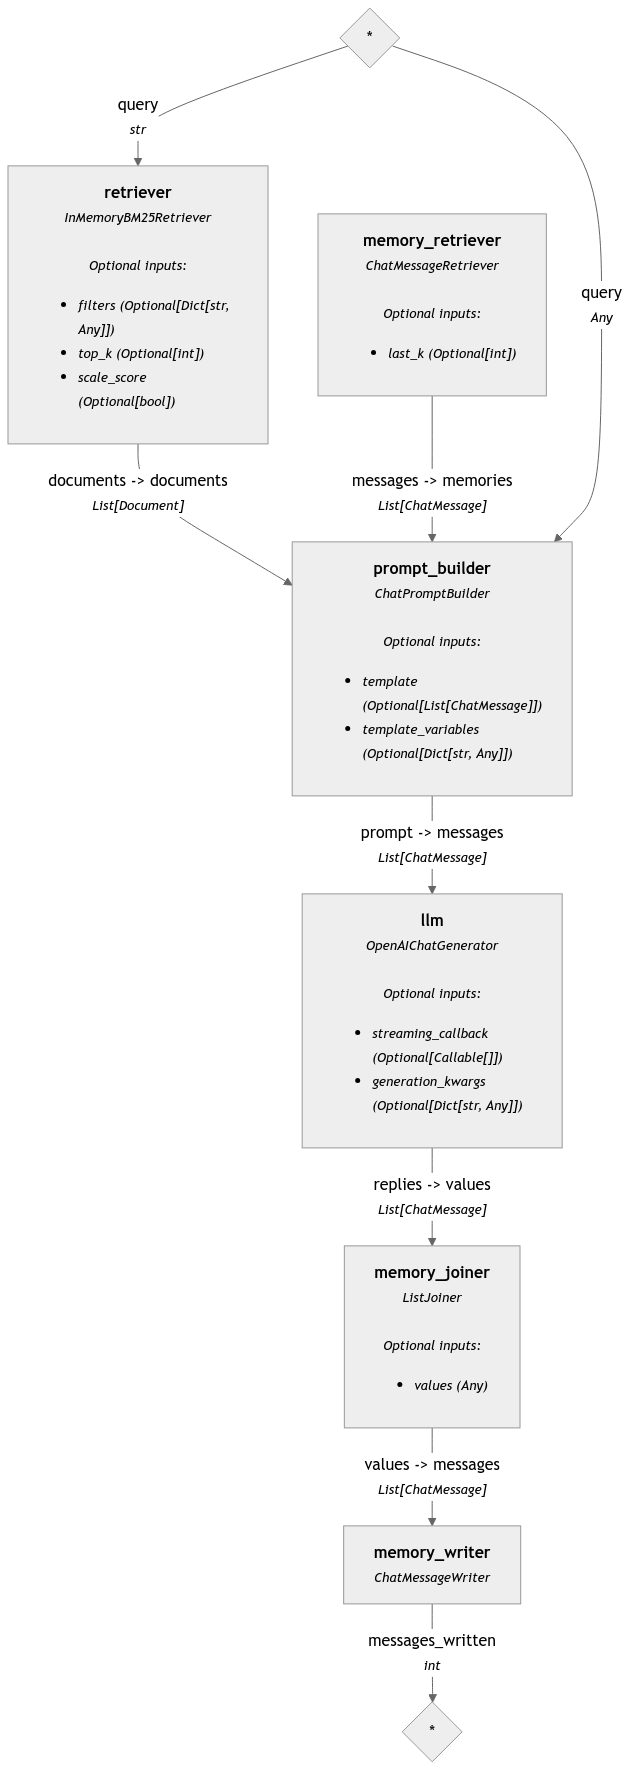

In [8]:
pipeline.show()

## Run the Pipeline

Test the pipeline with some queries. Ensure that every user query is also sent to the `memory_joiner` so that both the user queries and the LLM responses are stored together in the memory store.

Here are example queries you can try:

* *What does Rhodes Statue look like?*
* *Who built it?*

In [10]:
while True:
    messages = [system_message, user_message]
    question = input("Enter your question or Q to exit.\n🧑 ")
    if question=="Q":
        break

    res = pipeline.run(data={"retriever": {"query": question},
                             "prompt_builder": {"template": messages, "query": question},
                             "memory_joiner": {"values": [ChatMessage.from_user(question)]}},
                            include_outputs_from=["llm"])
    assistant_resp = res['llm']['replies'][0]
    print(f"🤖 {assistant_resp.content}")

Enter your question or Q to exit.
🧑 What does Rhodes Statue look like?
🤖 The Rhodes statue, known as the Colossus of Rhodes, would have featured a head with curly hair and spikes of bronze or silver flame radiating from it, similar to the depictions found on contemporary Rhodian coins. However, the exact appearance of the statue is not known, as there are no surviving images of it.
Enter your question or Q to exit.
🧑 Who built it?
🤖 The Hanging Gardens of Babylon are said to have been built by the Neo-Babylonian King Nebuchadnezzar II for his Median wife, Queen Amytis.
Enter your question or Q to exit.
🧑 Q


⚠️ If you followed the example queries, you'll notice that the second question was answered incorrectly. This happened because the retrieved documents weren't relevant to the user's query. The retrieval was based on the query "*Who built it?*", which doesn't have enough context to retrieve documents. Let's fix it with **rephrasing the query for search**.

## Prompt Template for Rephrasing User Query

In conversational systems, simply injecting memory into the prompt is not enough to perform RAG effectively. There needs to be a mechanism to rephrase the user's query based on the conversation history to ensure relevant documents are retrieved. For instance, if the first user query is "*What's the first name of Einstein?*" and the second query is "*Where was he born?*", the system should understand that "he" refers to Einstein. The rephrasing mechanism should then modify the second query to "*Where was Einstein born?*" to retrieve the correct documents.

We can use an LLM to rephrase the user's query. Let's create a prompt that instructs the LLM to rephrase the query, incorporating the conversation history, to make it suitable for retrieving relevant documents.

In [11]:
query_rephrase_template = """
        Rewrite the question for search while keeping its meaning and key terms intact.
        If the conversation history is empty, DO NOT change the query.
        Use conversation history only if necessary, and avoid extending the query with your own knowledge.
        If no changes are needed, output the current question as is.

        Conversation history:
        {% for memory in memories %}
            {{ memory.text }}
        {% endfor %}

        User Query: {{query}}
        Rewritten Query:
"""

## Build the Conversational RAG Pipeline

Now, let's incorporate query rephrasing into our pipeline by adding a new [PromptBuilder](https://docs.haystack.deepset.ai/docs/promptbuilder) with the prompt above, [OpenAIGenerator](https://docs.haystack.deepset.ai/docs/openaigenerator), and an [OutputAdapter](https://docs.haystack.deepset.ai/docs/outputadapter). The `OpenAIGenerator` will rephrase the user's query for search, and the `OutputAdapter` will convert the output from the `OpenAIGenerator` into the input for the `InMemoryBM25Retriever`. The rest of the pipeline will be the same.

In [12]:
from typing import List
from haystack import Pipeline
from haystack.components.builders import ChatPromptBuilder, PromptBuilder
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.generators import OpenAIGenerator
from haystack.components.converters import OutputAdapter

conversational_rag = Pipeline()

# components for query rephrasing
conversational_rag.add_component("query_rephrase_prompt_builder", PromptBuilder(query_rephrase_template))
conversational_rag.add_component("query_rephrase_llm", OpenAIGenerator())
conversational_rag.add_component("list_to_str_adapter", OutputAdapter(template="{{ replies[0] }}", output_type=str))

# components for RAG
conversational_rag.add_component("retriever", InMemoryBM25Retriever(document_store=document_store, top_k=3))
conversational_rag.add_component("prompt_builder", ChatPromptBuilder(variables=["query", "documents", "memories"], required_variables=["query", "documents", "memories"]))
conversational_rag.add_component("llm", OpenAIChatGenerator())

# components for memory
conversational_rag.add_component("memory_retriever", ChatMessageRetriever(memory_store))
conversational_rag.add_component("memory_writer", ChatMessageWriter(memory_store))
conversational_rag.add_component("memory_joiner", ListJoiner(List[ChatMessage]))

# connections for query rephrasing
conversational_rag.connect("memory_retriever", "query_rephrase_prompt_builder.memories")
conversational_rag.connect("query_rephrase_prompt_builder.prompt", "query_rephrase_llm")
conversational_rag.connect("query_rephrase_llm.replies", "list_to_str_adapter")
conversational_rag.connect("list_to_str_adapter", "retriever.query")

# connections for RAG
conversational_rag.connect("retriever.documents", "prompt_builder.documents")
conversational_rag.connect("prompt_builder.prompt", "llm.messages")
conversational_rag.connect("llm.replies", "memory_joiner")

# connections for memory
conversational_rag.connect("memory_joiner", "memory_writer")
conversational_rag.connect("memory_retriever", "prompt_builder.memories")

🚅 Components
  - query_rephrase_prompt_builder: PromptBuilder
  - query_rephrase_llm: OpenAIGenerator
  - list_to_str_adapter: OutputAdapter
  - retriever: InMemoryBM25Retriever
  - prompt_builder: ChatPromptBuilder
  - llm: OpenAIChatGenerator
  - memory_retriever: ChatMessageRetriever
  - memory_writer: ChatMessageWriter
  - memory_joiner: ListJoiner
🛤️ Connections
  - query_rephrase_prompt_builder.prompt -> query_rephrase_llm.prompt (str)
  - query_rephrase_llm.replies -> list_to_str_adapter.replies (List[str])
  - list_to_str_adapter.output -> retriever.query (str)
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.messages (List[ChatMessage])
  - llm.replies -> memory_joiner.values (List[ChatMessage])
  - memory_retriever.messages -> query_rephrase_prompt_builder.memories (List[ChatMessage])
  - memory_retriever.messages -> prompt_builder.memories (List[ChatMessage])
  - memory_joiner.values -> memory_writer.messages (List[ChatMes

## Let's have a conversation 😀

Now, run the pipeline with the relevant inputs. Instead of sending the query directly to the `retriever`, this time, pass it to the `query_rephrase_prompt_builder` to rephrase it.

Here are some example queries and follow ups you can try:

* *What does Rhodes Statue look like?* - *Who built it?* - *Did he destroy it?*
* *Where is Gardens of Babylon?* - *When was it built?*

In [14]:
while True:
    messages = [system_message, user_message]
    question = input("Enter your question or Q to exit.\n🧑 ")
    if question=="Q":
        break

    res = conversational_rag.run(data={"query_rephrase_prompt_builder": {"query": question},
                             "prompt_builder": {"template": messages, "query": question},
                             "memory_joiner": {"values": [ChatMessage.from_user(question)]}},
                            include_outputs_from=["llm","query_rephrase_llm"])
    search_query = res['query_rephrase_llm']['replies'][0]
    print(f"   🔎 Search Query: {search_query}")
    assistant_resp = res['llm']['replies'][0]
    print(f"🤖 {assistant_resp.text}")

Enter your question or Q to exit.
🧑 Where is Gardens of Babylon? 
   🔎 Search Query: Where are the Hanging Gardens of Babylon located?
🤖 The Hanging Gardens of Babylon were said to be located in the ancient city of Babylon, near present-day Hillah, Babil province, in Iraq.
Enter your question or Q to exit.
🧑 When was it built?
   🔎 Search Query: When was the Hanging Gardens of Babylon built?
🤖 The Hanging Gardens of Babylon are said to have been built during the reign of King Nebuchadnezzar II, who ruled between 605 and 562 BC.
Enter your question or Q to exit.
🧑 Q


✅ Notice that this time, with the help of query rephrasing, we've built a conversational RAG pipeline that can handle follow-up queries and retrieve the relevant documents.